# Load checkpoint and imports

In [2]:
import sys
import warnings

import pandas as pd

warnings.filterwarnings('ignore') 
parent_dir = "/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024"
# parent_dir="/Volumes/work/phd/MoLFormer_N2024"
sys.path.append(parent_dir)
# parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
# sys.path.append(parent_dir)

In [17]:
import pandas as pd
from utils.util_alignment import set_seeds
from utils.visualization_helper import *  
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
from constants import *

In [4]:
base_path= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/'
# base_path= '../../../../T5 EVO/alignment_olfaction_datasets/'
results_path = 'curated_datasets/dfs_result/regression/'

In [5]:
seed = 2024
set_seeds(seed)

In [6]:
times=30
n_components=20

# Helper Methods

In [7]:
def normalize_rmse(df,min_max,j):
    max_values = min_max.max()
    min_values = min_max.min()
    min_max.columns = ['Dataset','Type']+df.columns.values.tolist()[:j]
    # Drop 'Dataset' and 'Type' as they are not numeric columns
    min_values = min_values.drop(['Dataset', 'Type'])
    max_values = max_values.drop(['Dataset', 'Type'])
    for i,col in enumerate(df.columns[:j]):
        df[col] = np.sqrt(df[col]) / (max_values[i] - min_values[i])
    return df

In [8]:
def proccess_df_for_ICC(csv_results,ds='keller',layer=13):
    
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df=pd.read_csv(base_path+results_path+csv_results)
    df = df[df['layer'] == layer]
    columns_predicted = [task+'_predicted' for task in tasks]
    columns_true= [task+'_true' for task in tasks]
    df = df.drop_duplicates(subset=['model','CID'],inplace=False)
    df_predictions = df[['model','CID']+columns_predicted]
    df_true = df[['model','CID']+columns_true]
    df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
    df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
    df_melted_true['model'] = 'subjects_average' 
    df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
    df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
    return df_concatenated

In [9]:
def compute_ICC_mvm_permolecul_avgsubj(df_concatenated,model_list,model1='molformer'):
    results_dict = {}
    # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}

        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            inte_class_corr = pg.intraclass_corr(data=group, targets='CID', raters='model',ratings='value', nan_policy='omit')
            print(variable, inte_class_corr)
            inte_class_corr['variable'] = variable
            inte_class_corr['model_2'] = model2
            results_dict[model2][variable] = inte_class_corr
            
            #save result in a dictioney with model ad variable as key
        
        
    rows = []
    for model, variables in results_dict.items():
        row = {'model_2': model}
        for variable, result in variables.items():
            row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
        rows.append(row)
    df_results = pd.DataFrame(rows)
            
            
            # dfs.append(inte_class_corr)            
    return df_results
    

In [10]:
def plot_miguel_favorite(df_melted_true,df_melted_predicted):
    plt.figure(figsize=(80, 80))
    plt.xticks(rotation=90)
    sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_melted_true['variable'].unique()):
        category_fliers = df_melted_true[df_melted_true['variable'] == category]
        # category_fliers['value'] = abs(category_fliers['value'])
        x_positions = [i] * len(category_fliers)
        sns.scatterplot(x=x_positions, y=category_fliers['value'], color='red', s=100, marker='o')
    
    # Display the plot
    plt.show()

In [26]:
def visualoze_violinplot(df_results_all,ds):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df_results_all_melt = pd.melt(df_results_all, id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    df_results_all_melt_pom = df_results_all_melt[df_results_all_melt['model_2']=='pom']
    df_results_all_melt_molformer = df_results_all_melt[df_results_all_melt['model_2']=='molformer']
    df_results_all_melt_dam = df_results_all_melt[df_results_all_melt['model_2']=='alva']
    df_results_all_melt_tov = df_results_all_melt[~df_results_all_melt['model_2'].isin(['subjects_average','molformer','pom','alva'])]
    
    
    
    plt.figure(figsize=(80, 80))
    sns.violinplot(data=df_results_all_melt_tov, x="variable", y="ICC")
    
    plt.xticks(rotation=90)
    # sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_results_all_melt_molformer['variable'].unique()):
        category_fliers_molformer = df_results_all_melt_molformer[df_results_all_melt_molformer['variable'] == category]
        category_fliers_pom = df_results_all_melt_pom[df_results_all_melt_pom['variable'] == category]
        category_fliers_dam = df_results_all_melt_dam[df_results_all_melt_dam['variable'] == category]
        x_positions = [i] * len(category_fliers_molformer)
        sns.scatterplot(x=x_positions, y=category_fliers_molformer['ICC'], color='red', s=400, marker='o')
        sns.scatterplot(x=x_positions, y=category_fliers_pom['ICC'], color='yellow', s=400, marker='o')
        sns.scatterplot(x=x_positions, y=category_fliers_dam['ICC'], color='green', s=400, marker='o')
    
    # Display the plot
    plt.show()
    
    

In [11]:
# def compute_ICC_mvm_persubjpain(df_concatenated,model_list,model1='molformer'):
#     results_dict = {}
#     # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
#     for model2 in model_list:
#         df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
#         # grouped = df_concatenated_model.groupby('variable')
#         results_dict[model2] = {}
# 
#         # for variable, group in grouped:
#         # group = group.drop('variable',axis=1)
#         inte_class_corr = pg.intraclass_corr(data=df_concatenated_model, targets='CID', raters='model',ratings='value', nan_policy='omit')
#         print(variable, inte_class_corr)
#         inte_class_corr['variable'] = variable
#         inte_class_corr['model_2'] = model2
#         results_dict[model2][variable] = inte_class_corr
#             
#             #save result in a dictioney with model ad variable as key
#         
#         
#     rows = []
#     for model, variables in results_dict.items():
#         row = {'model_2': model}
#         for variable, result in variables.items():
#             row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
#         rows.append(row)
#     df_results = pd.DataFrame(rows)
#             
#             
#             # dfs.append(inte_class_corr)            
#     return df_results
#     

# Extracting Representations

## Keller

In [12]:
input_file_keller = base_path+'curated_datasets/mols_datasets/curated_keller2016_nona.csv' # or new downloaded file path
df_keller_temp=pd.read_csv(input_file_keller)

In [13]:
input_file_sagar = base_path+'curated_datasets/mols_datasets/curated_sagar_subjects_nonaminus.csv' # or new downloaded file path
df_sagar_temp=pd.read_csv(input_file_sagar)

In [14]:
df_keller_cor_pom=pd.read_csv(base_path+results_path+"df_keller_cor_pom.csv")
df_keller_mse_pom=pd.read_csv(base_path+results_path+"df_keller_mse_pom.csv")
df_keller_cor_alva=pd.read_csv(base_path+results_path+"df_keller_cor_alva.csv")
df_keller_mse_alva=pd.read_csv(base_path+results_path+"df_keller_mse_alva.csv")
df_keller_corrs_molfomer=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomer.csv")
df_keller_mses_molfomer=pd.read_csv(base_path+results_path+"df_keller_mses_molfomer.csv")
df_keller_corrs_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomerfinetuned.csv")
df_keller_mses_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_mses_molfomerfinetuned.csv")

In [15]:
# df_keller_corrs_molfomer

['molformer', 'molformerfinetuned', 'pom', 'alva']


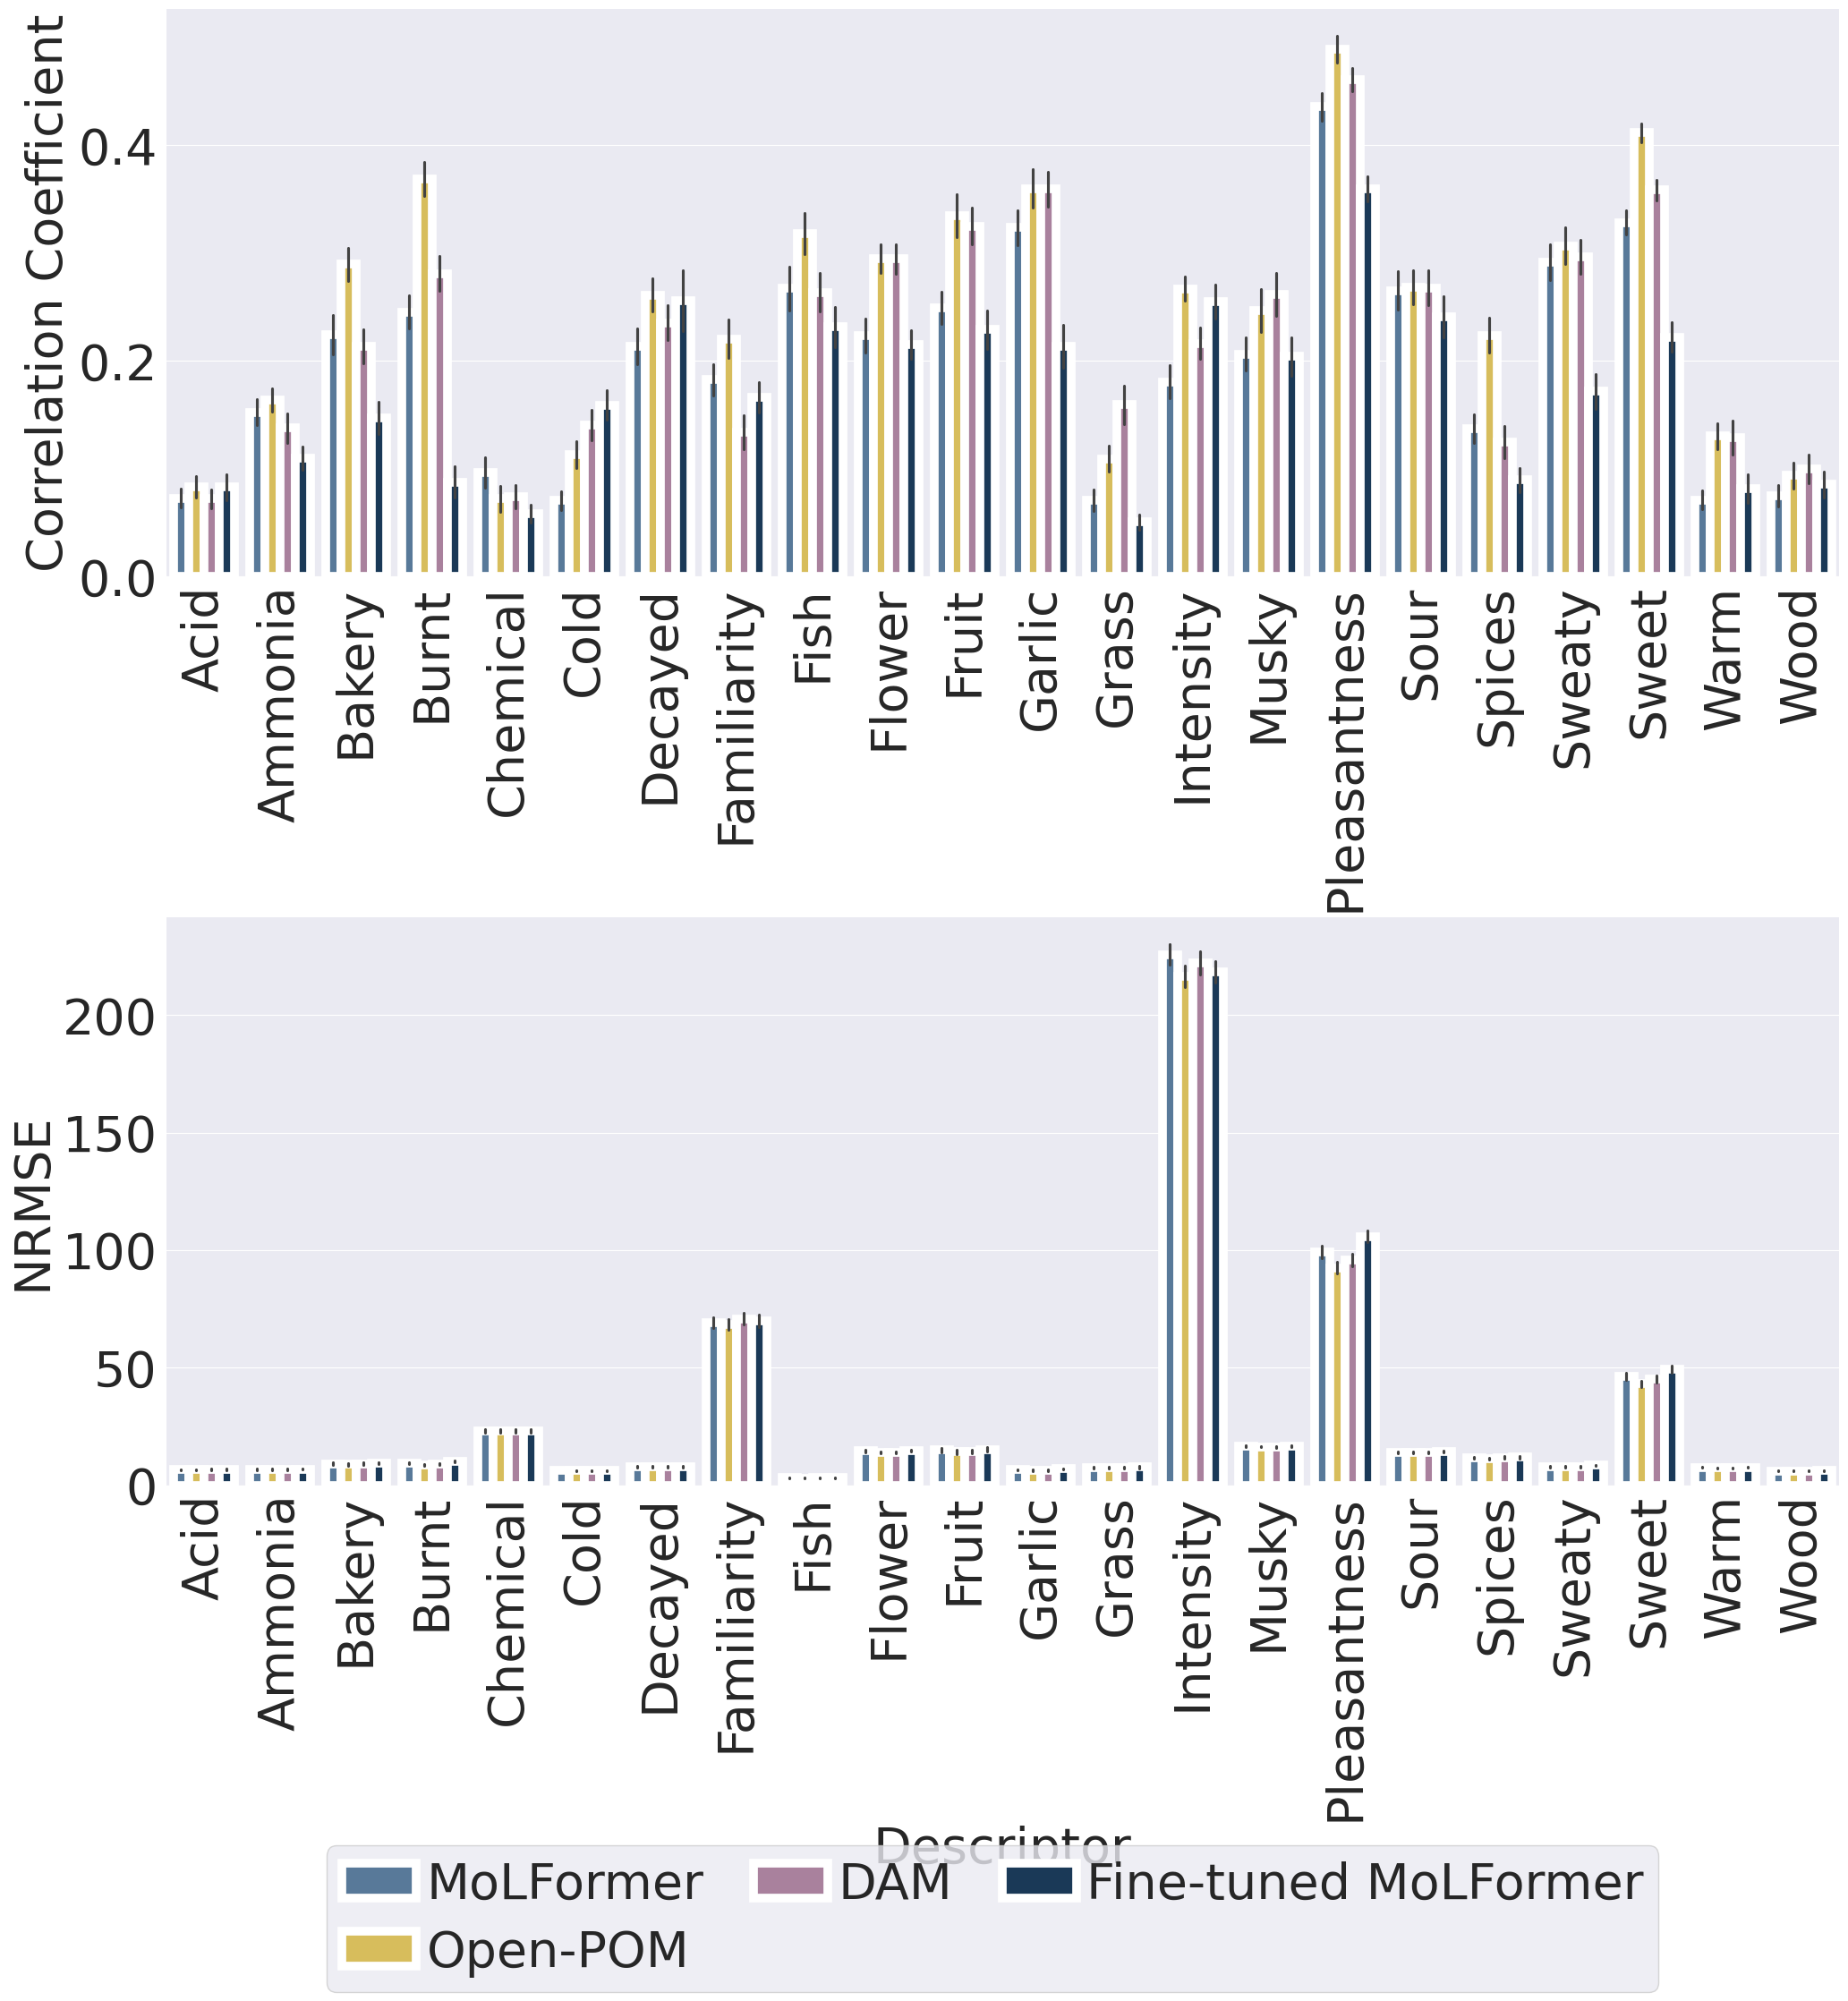

In [16]:
trend_learning_molformer =  post_process_dataframe(df_keller_corrs_molfomer,df_keller_mses_molfomer,df_keller_corrs_molfomerfinetuned,df_keller_mses_molfomerfinetuned,df_keller_cor_pom,df_keller_cor_alva,df_keller_mse_pom,df_keller_mse_alva,keller_tasks,"keller_regression")
# trend_learning_molformer['dataset']='keller'

In [19]:
df_concatenated_keller = proccess_df_for_ICC("keller_predictions.csv", ds='keller',layer=13)
df_keller_temp = df_keller_temp.rename(columns={'Subject': 'model'})
df_keller_subjects = df_keller_temp.melt(id_vars=['model', 'CID'], value_vars=keller_tasks, var_name='variable', value_name='value')
df_keller_subjects['model'] = df_keller_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_keller_all = pd.concat([df_concatenated_keller, df_keller_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,56)]+['molformer','pom','alva']


In [21]:
df_results_keller_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    df_results_keller = compute_ICC_mvm_permolecul_avgsubj(df_keller_all,model_list,model1=model_1)
    df_results_keller['model_1'] = model_1
    df_results_keller_all_antonio_faviorte = pd.concat([df_results_keller_all_antonio_faviorte,df_results_keller],axis=0)

In [ ]:
visualoze_violinplot(df_results_keller_all_antonio_faviorte,ds='keller')


In [22]:
#create empty dataframe to store the results
# df_results_keller_all = pd.DataFrame()
# for model_1 in ['molformer','pom','alva']:
#     df_results_keller = compute_ICC_mvm_permolecul_avgsubj(df_keller_all,model_list,model1=model_1)
#     df_results_keller['model_1'] = model_1
#     df_results_keller_all = pd.concat([df_results_keller_all,df_results_keller],axis=0)

In [34]:
df_concatenated_sagar = proccess_df_for_ICC("sagar_predictions.csv", ds='sagar',layer=13)
df_sagar_temp = df_sagar_temp.rename(columns={'subject': 'model', 'cid': 'CID'})
df_sagar_subjects = df_sagar_temp.melt(id_vars=['model', 'CID'], value_vars=sagar_tasks, var_name='variable', value_name='value')
df_sagar_subjects['model'] = df_sagar_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_sagar_all = pd.concat([df_concatenated_sagar, df_sagar_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,4)]+['molformer','pom','alva']

In [ ]:
df_results_sagar_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    df_results_sagar = compute_ICC_mvm_permolecul_avgsubj(df_sagar_all,model_list,model1=model_1)
    df_results_sagar['model_1'] = model_1
    df_results_sagar_all_antonio_faviorte = pd.concat([df_results_sagar_all_antonio_faviorte,df_results_sagar],axis=0)



In [ ]:
visualoze_violinplot(df_results_sagar_all_antonio_faviorte,ds='sagar')


In [36]:
# df_results_sagar_all = pd.DataFrame()
# for model_1 in ['molformer','pom','alva']:
#     df_results_sagar = compute_ICC_mvm_permolecul_avgsubj(df_sagar_all,model_list,model1=model_1)
#     df_results_sagar['model_1'] = model_1
#     df_results_sagar_all = pd.concat([df_results_sagar_all,df_results_sagar],axis=0)

Bakery     Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.755423  7.177391  159  160  1.920602e-31   
1   ICC2     Single random raters  0.756219  7.374239  159  159  5.189012e-32   
2   ICC3      Single fixed raters  0.761172  7.374239  159  159  5.189012e-32   
3  ICC1k  Average raters absolute  0.860674  7.177391  159  160  1.920602e-31   
4  ICC2k    Average random raters  0.861190  7.374239  159  159  5.189012e-32   
5  ICC3k     Average fixed raters  0.864393  7.374239  159  159  5.189012e-32   

          CI95%  
0  [0.68, 0.81]  
1  [0.68, 0.82]  
2  [0.69, 0.82]  
3   [0.81, 0.9]  
4   [0.81, 0.9]  
5   [0.81, 0.9]  
Burnt     Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.714222  5.998427  159  160  7.717015e-27   
1   ICC2     Single random raters  0.714297  6.009612  159  159  9.111456e-27   
2   ICC3      Single fixed raters  0.714678  6.009

In [37]:
# df_results_keller_all_antonio_faviorte


In [42]:
# df_results_keller_all_antonio_faviorte_melt[df_results_keller_all_antonio_faviorte_melt['model_2']=='pom']

,model_1,model_2,variable,ICC
56,subjects_average,pom,Acid,-0.000491
114,subjects_average,pom,Ammonia,0.048511
172,subjects_average,pom,Bakery,0.076727
230,subjects_average,pom,Burnt,0.138736
288,subjects_average,pom,Chemical,0.025622
346,subjects_average,pom,Cold,0.033025
404,subjects_average,pom,Decayed,0.112931
462,subjects_average,pom,Familiarity,0.021751
520,subjects_average,pom,Fish,0.122108
578,subjects_average,pom,Flower,0.153045


In [ ]:
# df_sagar=pd.read_csv(base_path+results_path+'sagar_predictions.csv')
# columns_predicted = [task+'_predicted' for task in sagar_tasks]
# columns_true= [task+'_true' for task in sagar_tasks]
# df_sagar_predictions = df_sagar[['model','CID']+columns_predicted]
# df_sagar_true = df_sagar[['model','CID']+columns_true]
# df_sagar_melted_predicted= pd.melt(df_sagar_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
# df_sagar_melted_true = pd.melt(df_sagar_true, id_vars=['model','CID'], value_vars=columns_true)

In [ ]:
# for cid in df_sagar_melted_predicted['CID'].unique():
#     df_sagar_melted_predicted[df_sagar_melted_predicted['CID']==cid]
    

    
    
    
# plot_miguel_favorite(df_sagar_melted_true,df_sagar_melted_predicted)

In [38]:
def plot_ICC_resutls(df,ds):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    df_melted = df.melt(id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    
    # Create the scatter plot
    f = plt.figure(figsize=(35, 6))
    g = sns.scatterplot(data=df_melted, x='variable', y='ICC', hue='model_2', style='model_1',s=100,alpha=0.5)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)
    handles, labels = g.get_legend_handles_labels()
    g.get_legend().remove()
    print("labels",labels)
    f.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.95)
    labels = ['','','','','','Model','MoLFormer', 'Open-POM', 'DAM']
    f.legend(handles[-3:], labels[-3:], ncol=3, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=(0.52, -0.7),
              frameon=True, labelspacing=0.4, handletextpad=0.2, )
    # plt.legend(title='Smoker', loc='upper left',)
    plt.subplots_adjust(hspace=0.6)
    f.savefig("ICC_"+ds + ".pdf", bbox_inches='tight')
    # Show the plot
    plt.show()

In [ ]:
df_results_sagar_subjects = df_results_sagar_all[df_results_sagar_all['model_2']!='subjects_average']
plot_ICC_resutls(df_results_sagar_subjects,'sagar')
df_results_sagar_subjects = df_results_sagar_subjects.drop('model_2',axis=1)
#compute average over all the subjects
df_results_sagar_subjects.groupby('model_1').mean()
# df_results_sagar_subjects.groupby('model_1').select_dtypes(include=[np.number]).mean()


In [ ]:
plot_ICC_resutls(df_results_keller_all,'keller')

In [ ]:
# f2, ax = plt.subplots(2, 1, figsize=(22, 22))
# g1 = combine_visualize((df_results_keller[df_results_keller['model']=='molformer'], df_results_keller[df_results_keller['model']=='pom'],
#                            df_results_keller[df_results_keller['model']=='alva']), keller_tasks, ax[0], 'ICC',
#                            figure_name='ICC',abs=True)
# 
# g2= combine_visualize((df_results_sagar[df_results_sagar['model']=='molformer'], df_results_sagar[df_results_sagar['model']=='pom'],
#                             df_results_sagar[df_results_sagar['model']=='alva']), sagar_tasks, ax[1], 'ICC',
#                             figure_name='ICC',abs=True)
# 
# vertical_plot_tweak(f2, 'ICC', g1, g2)


In [ ]:

grouped_predicted = df_concatenated.groupby('variable')
# Initialize an empty dictionary to store the results
kappa_scores = {}

# For each group in group_predicted, compute interclass_corr between 

for (var_predicted) in zip(df_concatenated):
    pg.intraclass_corr(data=var_predicted, targets='value', raters='model',
                         ratings='Scores')
    
    # pg.intraclass_corr()
    # kappa = cohen_kappa_score(group_predicted['value'], group_true['value'])
    # kappa_scores[var_predicted] = kappa

# Print the results
for variable, kappa in kappa_scores.items():
    print(f"Cohen's kappa for {variable}: {kappa}")




#inter-rater agreement for pair of molecules

In [ ]:
# we want to plot m plots which m is the number of molecules in the dataset. for eah molecule we have n boxplot which is n tasks. boxplot show the distribution over subjects and we show the prediction as a line in the boxplot. We average over all the runs available in ds results.


#plot a boxplot for the average over all the tasks per _predicted descriptor_ 

#define plot_boxplot function
#plot a boxplot for the average over all the tasks per _predicted descriptor_
# def plot_boxplot(df, tasks, dataset):
#     for i in range(len(df)):
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(data=df.iloc[i], showfliers=False)
#         plt.title(f'{dataset} - {tasks[i]}')
#         plt.xlabel('Subjects')
#         plt.ylabel('Predicted Value')
#         plt.show()
#            
# plot_boxplot(df_keller_predictions,keller_tasks,"keller_regression")

In [ ]:
cohen_kappa_score(df_keller_predictions_lastlayer_notruedduplicate['LogP_true'],df_keller_predictions_lastlayer_notruedduplicate['LogP_predicted'])

 Sagar

In [ ]:
input_file_sagar = base_path+'/curated_datasets/mols_datasets/curated_sagar_subjects_nonaminus.csv' # or new downloaded file path
df_sagar_temp=pd.read_csv(input_file_sagar)
sagar_tasks= df_sagar_temp.columns.to_list()[1:-5]

In [ ]:
# corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva =compute_correlation_keller(times , n_components,per_descritor=False)
df_sagar_cor_pom=pd.read_csv(base_path+results_path+"df_sagar_cor_pom.csv")
df_sagar_mse_pom=pd.read_csv(base_path+results_path+"df_sagar_mse_pom.csv")
df_sagar_cor_alva=pd.read_csv(base_path+results_path+"df_sagar_cor_alva.csv")
df_sagar_mse_alva=pd.read_csv(base_path+results_path+"df_sagar_mse_alva.csv")
df_sagar_corrs_molfomer=pd.read_csv(base_path+results_path+"df_sagar_corrs_molfomer.csv")
df_sagar_mses_molfomer=pd.read_csv(base_path+results_path+"df_sagar_mses_molfomer.csv")

In [ ]:
trend_learning_molformer_sagar = post_process_dataframe(df_sagar_corrs_molfomer,df_sagar_mses_molfomer,df_sagar_cor_pom,df_sagar_cor_alva,df_sagar_mse_pom,df_sagar_mse_alva,sagar_tasks,"sagar_regression")